# Imports

In [33]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters

# Understanding the Data
In this section, we aim to better understand the data through a series of visualizations.

## 1. Shelter Occupancy Data

In [6]:
file_paths = ['/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2021.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2022.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2023.csv']

dataframes = [pd.read_csv(file) for file in file_paths]

for file in file_paths:
    try:
        df = pd.read_csv(file)
        if df.empty:
            print(f"The file at {file} is empty.")
        else:
            print(f"Loaded {len(df)} rows from {file}")
            dataframes.append(df)
    except FileNotFoundError:
        print(f"No file found at {file}")
    except pd.errors.EmptyDataError:
        print(f"File at {file} is empty or corrupted.")

if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"The combined dataframe has {len(combined_df)} rows.")
else:
    print("No data has been loaded. Please check the file paths and contents.")

Loaded 50944 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2021.csv
Loaded 49478 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2022.csv
Loaded 48345 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2023.csv
The combined dataframe has 297534 rows.


In [12]:
# COLUMN SELECTION -------------------------------------------------------------

combined_df = combined_df.dropna(subset=['CAPACITY_TYPE'])

# Separate data based on Capacity Type --> Bed Based and Room Based
bed_capacity_df = combined_df[combined_df['CAPACITY_TYPE'] == 'Bed Based Capacity'].copy()
room_capacity_df = combined_df[combined_df['CAPACITY_TYPE'] == 'Room Based Capacity'].copy()

# Removing unnecessary columns
columns_to_drop = ['_id', 'ORGANIZATION_ID', 'SHELTER_ID', 'LOCATION_POSTAL_CODE', 'PROGRAM_ID', 'SECTOR', 'PROGRAM_MODEL', 'SERVICE_USER_COUNT', 'OVERNIGHT_SERVICE_TYPE', 'PROGRAM_AREA', 'ORGANIZATION_NAME', 'SHELTER_GROUP', 'LOCATION_NAME', 'LOCATION_ADDRESS', 'LOCATION_CITY', 'LOCATION_PROVINCE', 'PROGRAM_NAME']
bed_columns_to_drop = ['CAPACITY_ACTUAL_ROOM', 'CAPACITY_FUNDING_ROOM', 'OCCUPIED_ROOMS', 'UNOCCUPIED_ROOMS', 'UNAVAILABLE_ROOMS', 'OCCUPANCY_RATE_ROOMS']
room_columns_to_drop = ['CAPACITY_ACTUAL_BED', 'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS', 'UNAVAILABLE_BEDS', 'OCCUPANCY_RATE_BEDS']

bed_capacity_df = bed_capacity_df.drop(columns_to_drop, axis=1)
bed_capacity_df = bed_capacity_df.drop(bed_columns_to_drop, axis=1)

room_capacity_df = room_capacity_df.drop(columns_to_drop, axis=1)
room_capacity_df = room_capacity_df.drop(room_columns_to_drop, axis=1)

# DATA PREPROCESSING -----------------------------------------------------------

# Convert OCCUPANCY_DATE to datetime
bed_capacity_df['OCCUPANCY_DATE'] = pd.to_datetime(bed_capacity_df['OCCUPANCY_DATE'],format='mixed')
room_capacity_df['OCCUPANCY_DATE'] = pd.to_datetime(room_capacity_df['OCCUPANCY_DATE'],format='mixed')

# Extract year, month, and day as separate features
bed_capacity_df['YEAR'] = bed_capacity_df['OCCUPANCY_DATE'].dt.year
bed_capacity_df['MONTH'] = bed_capacity_df['OCCUPANCY_DATE'].dt.month
bed_capacity_df['DAY'] = bed_capacity_df['OCCUPANCY_DATE'].dt.day

room_capacity_df['YEAR'] = room_capacity_df['OCCUPANCY_DATE'].dt.year
room_capacity_df['MONTH'] = room_capacity_df['OCCUPANCY_DATE'].dt.month
room_capacity_df['DAY'] = room_capacity_df['OCCUPANCY_DATE'].dt.day

print(bed_capacity_df.head())
print(room_capacity_df.head())

   OCCUPANCY_DATE  LOCATION_ID       CAPACITY_TYPE  CAPACITY_ACTUAL_BED  \
5      2021-01-01       1051.0  Bed Based Capacity                  8.0   
10     2021-01-01       1029.0  Bed Based Capacity                 24.0   
11     2021-01-01       1102.0  Bed Based Capacity                 12.0   
21     2021-01-01       1009.0  Bed Based Capacity                 12.0   
25     2021-01-01       1065.0  Bed Based Capacity                 12.0   

    CAPACITY_FUNDING_BED  OCCUPIED_BEDS  UNOCCUPIED_BEDS  UNAVAILABLE_BEDS  \
5                    8.0            6.0              2.0               0.0   
10                  33.0           22.0              2.0               9.0   
11                  15.0            8.0              4.0               3.0   
21                  12.0           10.0              2.0               0.0   
25                  20.0           11.0              1.0               8.0   

    OCCUPANCY_RATE_BEDS  YEAR  MONTH  DAY  
5                 75.00  2021      1

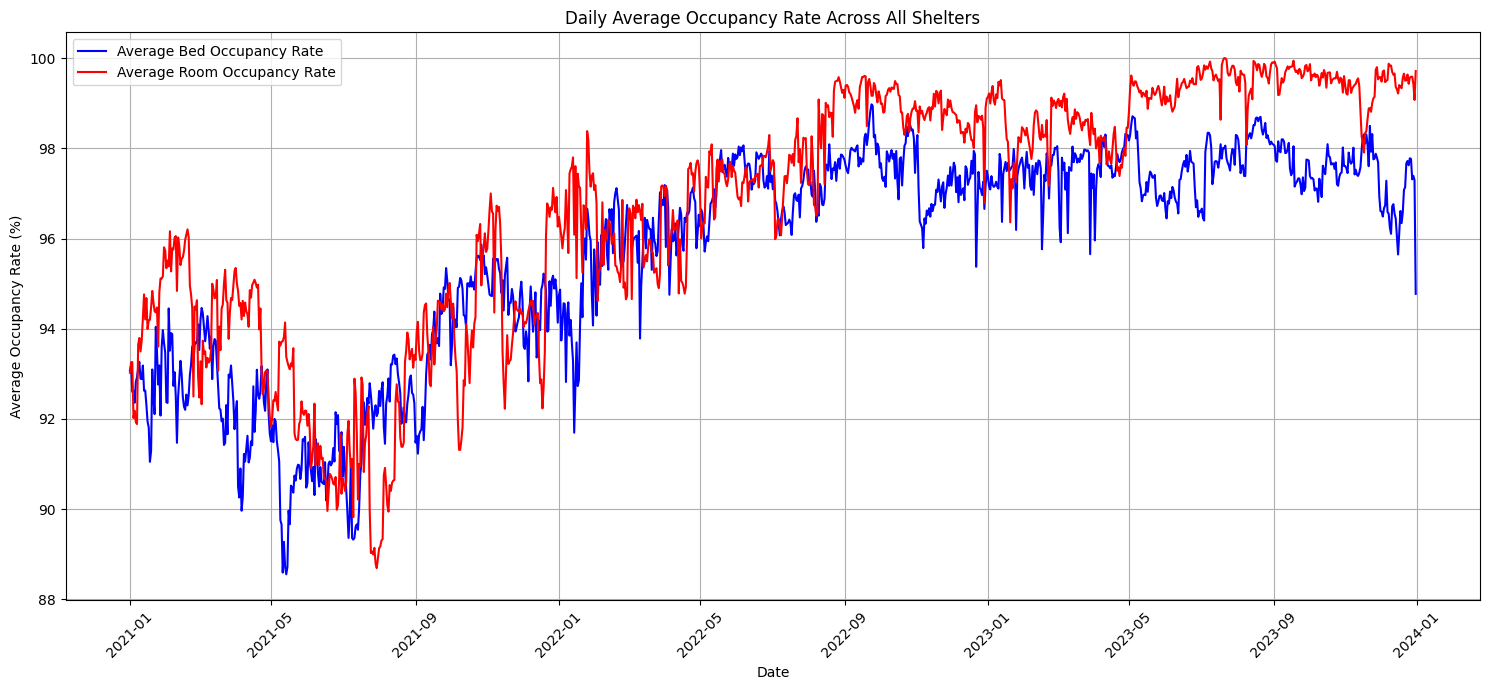

In [13]:
# PLOTTING AVERAGE DEMAND TO VISUALIZE -----------------------------------------

# Calculate daily average occupancy rate for beds
daily_avg_bed_occupancy = bed_capacity_df.groupby('OCCUPANCY_DATE')['OCCUPANCY_RATE_BEDS'].mean().reset_index()

# Calculate daily average occupancy rate for rooms
daily_avg_room_occupancy = room_capacity_df.groupby('OCCUPANCY_DATE')['OCCUPANCY_RATE_ROOMS'].mean().reset_index()

# Plotting
plt.figure(figsize=(15, 7))

# Plot for beds
plt.plot(daily_avg_bed_occupancy['OCCUPANCY_DATE'], daily_avg_bed_occupancy['OCCUPANCY_RATE_BEDS'], label='Average Bed Occupancy Rate', color='blue')

# Plot for rooms
plt.plot(daily_avg_room_occupancy['OCCUPANCY_DATE'], daily_avg_room_occupancy['OCCUPANCY_RATE_ROOMS'], label='Average Room Occupancy Rate', color='red')

plt.title('Daily Average Occupancy Rate Across All Shelters')
plt.xlabel('Date')
plt.ylabel('Average Occupancy Rate (%)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.tight_layout()

plt.show()

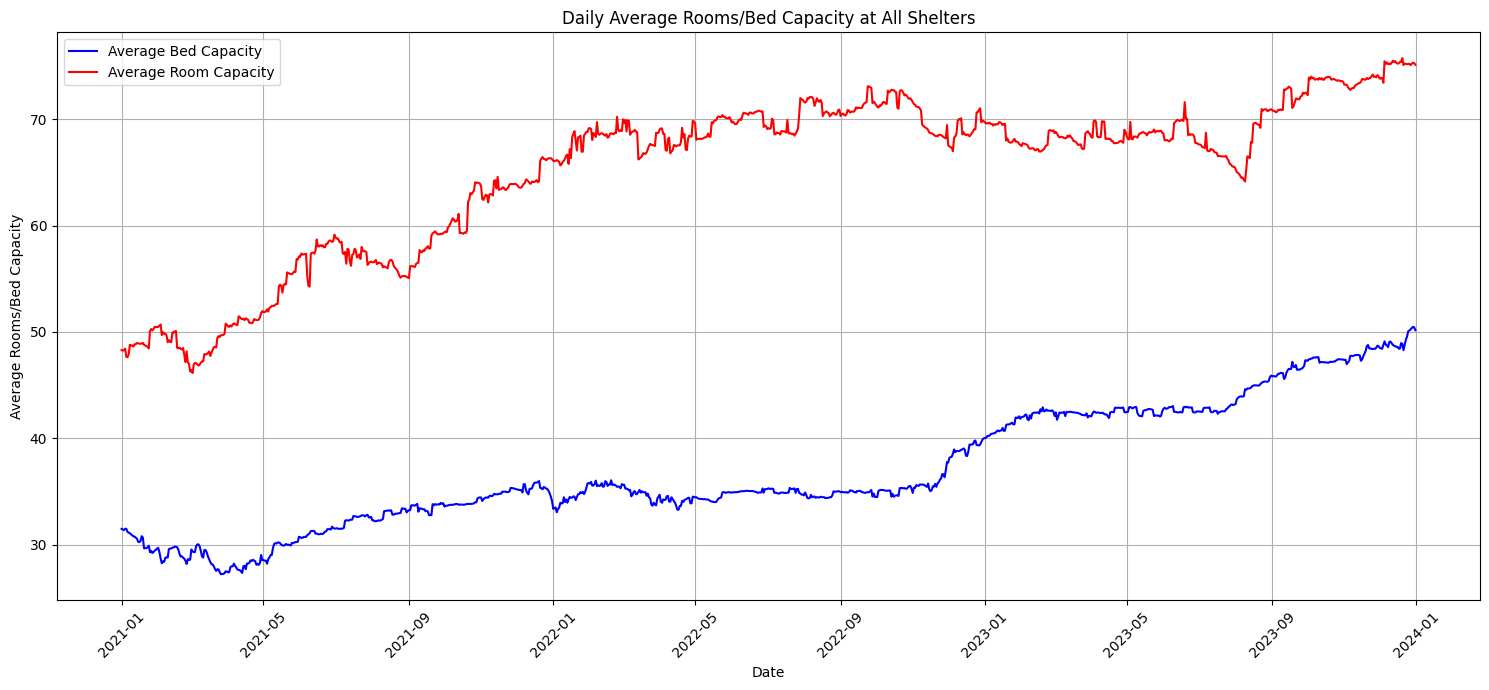

In [17]:
# PLOTTING AVAILABILITY TO VISUALIZE -----------------------------------------

# Calculate daily average occupancy rate for beds
daily_avg_bed_occupancy = bed_capacity_df.groupby('OCCUPANCY_DATE')['CAPACITY_ACTUAL_BED'].mean().reset_index()

# Calculate daily average occupancy rate for rooms
daily_avg_room_occupancy = room_capacity_df.groupby('OCCUPANCY_DATE')['CAPACITY_ACTUAL_ROOM'].mean().reset_index()

# Plotting
plt.figure(figsize=(15, 7))

# Plot for beds
plt.plot(daily_avg_bed_occupancy['OCCUPANCY_DATE'], daily_avg_bed_occupancy['CAPACITY_ACTUAL_BED'], label='Average Bed Capacity', color='blue')

# Plot for rooms
plt.plot(daily_avg_room_occupancy['OCCUPANCY_DATE'], daily_avg_room_occupancy['CAPACITY_ACTUAL_ROOM'], label='Average Room Capacity', color='red')

plt.title('Daily Average Rooms/Bed Capacity at All Shelters')
plt.xlabel('Date')
plt.ylabel('Average Rooms/Bed Capacity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.tight_layout()

plt.show()

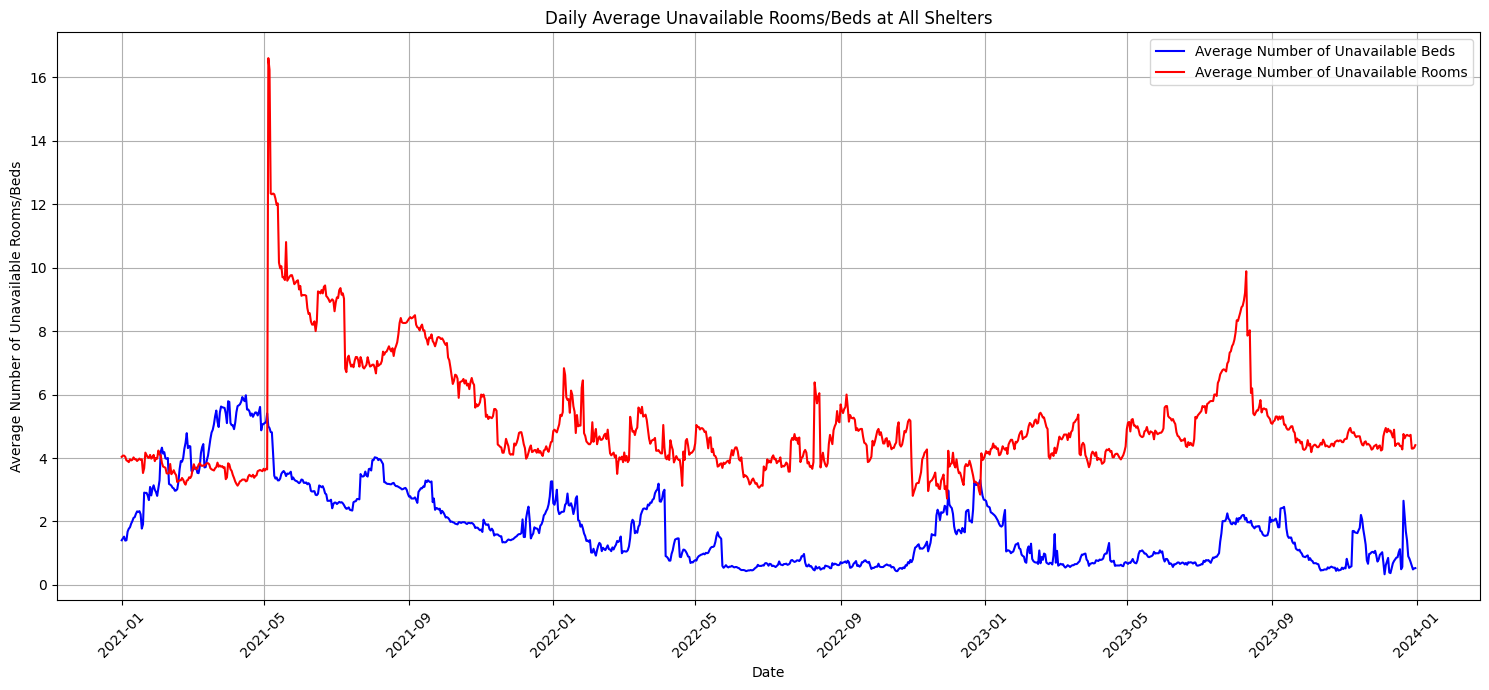

In [16]:
# PLOTTING UNAVAILABILITY TO VISUALIZE -----------------------------------------

# Calculate daily average occupancy rate for beds
daily_avg_bed_occupancy = bed_capacity_df.groupby('OCCUPANCY_DATE')['UNAVAILABLE_BEDS'].mean().reset_index()

# Calculate daily average occupancy rate for rooms
daily_avg_room_occupancy = room_capacity_df.groupby('OCCUPANCY_DATE')['UNAVAILABLE_ROOMS'].mean().reset_index()

# Plotting
plt.figure(figsize=(15, 7))

# Plot for beds
plt.plot(daily_avg_bed_occupancy['OCCUPANCY_DATE'], daily_avg_bed_occupancy['UNAVAILABLE_BEDS'], label='Average Number of Unavailable Beds', color='blue')

# Plot for rooms
plt.plot(daily_avg_room_occupancy['OCCUPANCY_DATE'], daily_avg_room_occupancy['UNAVAILABLE_ROOMS'], label='Average Number of Unavailable Rooms', color='red')

plt.title('Daily Average Unavailable Rooms/Beds at All Shelters')
plt.xlabel('Date')
plt.ylabel('Average Number of Unavailable Rooms/Beds')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.tight_layout()

plt.show()

## 2. Weather Data

In [19]:
weather_file_paths = ['/content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2021_P1D.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2022_P1D.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2023_P1D.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2024_P1D.csv']

dataframes = [pd.read_csv(file) for file in weather_file_paths]

for file in weather_file_paths:
    try:
        weather_df = pd.read_csv(file)
        if df.empty:
            print(f"The file at {file} is empty.")
        else:
            print(f"Loaded {len(weather_df)} rows from {file}")
            dataframes.append(weather_df)
    except FileNotFoundError:
        print(f"No file found at {file}")
    except pd.errors.EmptyDataError:
        print(f"File at {file} is empty or corrupted.")

if dataframes:
    combined_weather_df = pd.concat(dataframes, ignore_index=True)
    print(f"The combined dataframe has {len(combined_weather_df)} rows.")
else:
    print("No data has been loaded. Please check the file paths and contents.")

Loaded 365 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2021_P1D.csv
Loaded 365 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2022_P1D.csv
Loaded 365 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2023_P1D.csv
Loaded 366 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/en_climate_daily_ON_6158355_2024_P1D.csv
The combined dataframe has 2922 rows.


In [21]:
# Removing unnecessary columns
columns_to_drop = ['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Data Quality', 'Max Temp Flag', 'Min Temp Flag', 'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 'Total Precip Flag', 'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag']

weather_df = combined_weather_df.drop(columns_to_drop, axis=1)

print(weather_df.head())

    Date/Time  Year  Month  Day  Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  \
0  2021-01-01  2021      1    1            2.5           -1.0             0.7   
1  2021-01-02  2021      1    2            2.2           -0.9             0.7   
2  2021-01-03  2021      1    3            2.1            0.2             1.1   
3  2021-01-04  2021      1    4            1.7           -0.1             0.8   
4  2021-01-05  2021      1    5            1.6            0.6             1.1   

   Total Precip (mm)  
0                6.8  
1               10.8  
2                1.7  
3                0.0  
4                0.4  


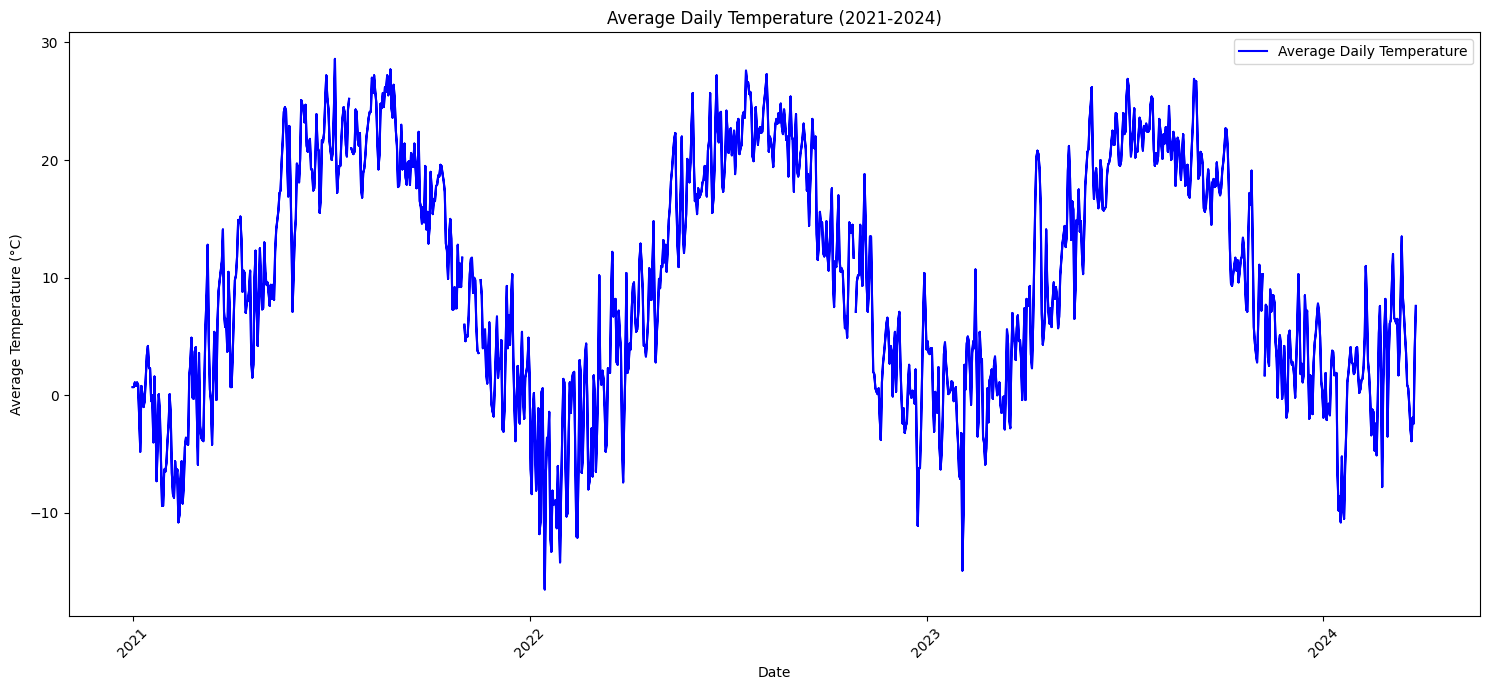

In [36]:
# PLOTTING DAILY AVERAGE TEMPERATURE -----------------------------------------

weather_df['Date/Time'] = pd.to_datetime(weather_df['Date/Time'])

register_matplotlib_converters()

plt.figure(figsize=(15, 7))

plt.plot(weather_df['Date/Time'], weather_df['Mean Temp (°C)'], label='Average Daily Temperature', color='blue')

plt.title('Average Daily Temperature (2021-2024)')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend()

# Set the locator for major ticks to show one tick per year and format it to show the year only
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()

plt.show()


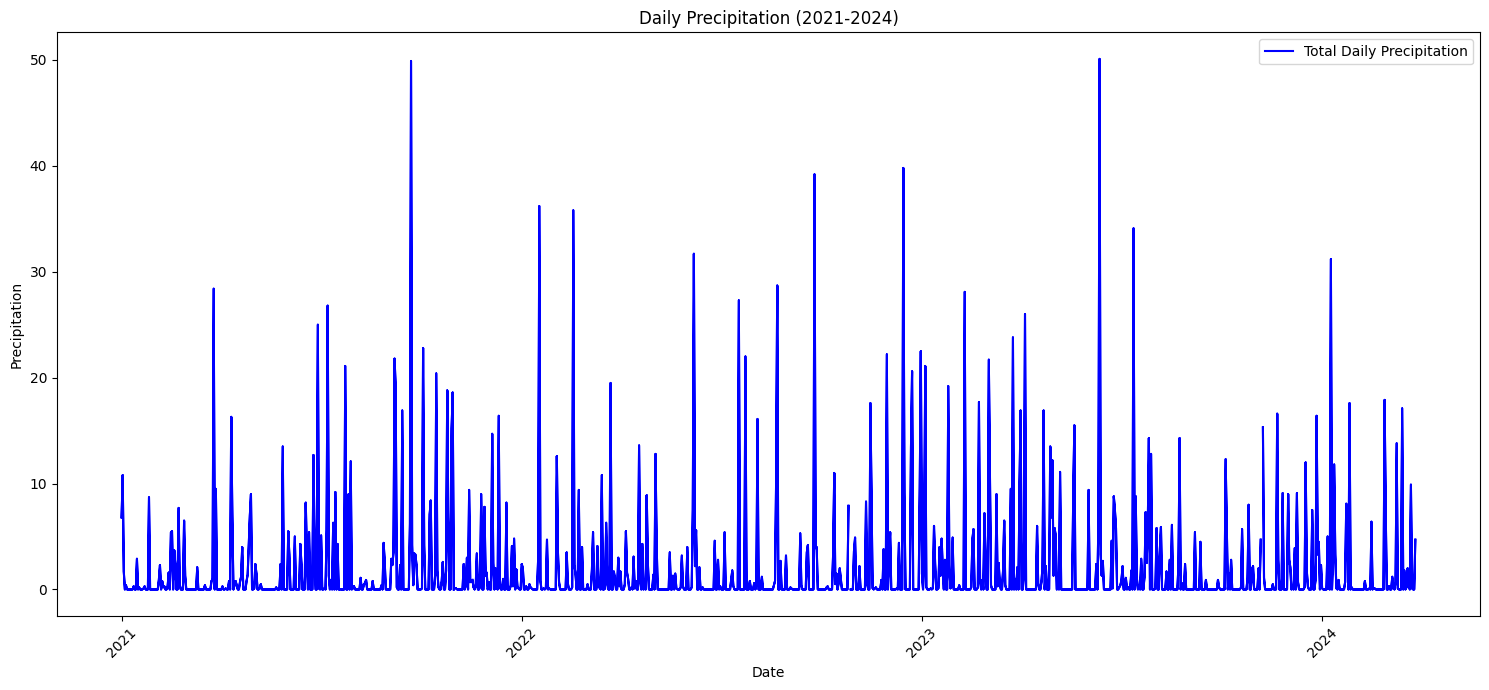

In [37]:
# PLOTTING DAILY PRECIPITATION TEMPERATURE -----------------------------------------

weather_df['Date/Time'] = pd.to_datetime(weather_df['Date/Time'])

register_matplotlib_converters()

plt.figure(figsize=(15, 7))

plt.plot(weather_df['Date/Time'], weather_df['Total Precip (mm)'], label='Total Daily Precipitation', color='blue')

plt.title('Daily Precipitation (2021-2024)')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend()

# Set the locator for major ticks to show one tick per year and format it to show the year only
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()

plt.show()


## 3. Housing Information

In [47]:
housing_file_path = '/content/drive/MyDrive/Colab Notebooks/Borealis Project/Housing.csv'

housing_df = pd.read_csv(housing_file_path)

print(housing_df.head())

  REF_DATE              GEO           DGUID New housing price indexes  \
0  1981-01           Canada  2016A000011124    Total (house and land)   
1  1981-01           Canada  2016A000011124                House only   
2  1981-01           Canada  2016A000011124                 Land only   
3  1981-01  Atlantic Region      2016A00011    Total (house and land)   
4  1981-01  Atlantic Region      2016A00011                House only   

                 UOM  UOM_ID SCALAR_FACTOR  SCALAR_ID      VECTOR  COORDINATE  \
0  Index, 201612=100     347         units          0  v111955442         1.1   
1  Index, 201612=100     347         units          0  v111955443         1.2   
2  Index, 201612=100     347         units          0  v111955444         1.3   
3  Index, 201612=100     347         units          0  v111955445         2.1   
4  Index, 201612=100     347         units          0  v111955446         2.2   

   VALUE STATUS  SYMBOL  TERMINATED  DECIMALS  
0   38.2    NaN     NaN   

In [54]:
toronto_housing_df = housing_df[housing_df['GEO'].str.contains('Toronto, Ontario', na=False)]
house_df = toronto_housing_df[toronto_housing_df['New housing price indexes'] == 'Total (house and land)']

# Ensure 'REF_DATE' is in datetime format
house_df['REF_DATE'] = pd.to_datetime(house_df['REF_DATE'])

house_df = house_df[~((house_df['REF_DATE'].dt.year >= 1981) & (house_df['REF_DATE'].dt.year <= 2010))]

columns_to_drop = ['DGUID', 'UOM', 'SCALAR_FACTOR', 'UOM_ID', 'New housing price indexes', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS']

house_df = house_df.drop(columns_to_drop, axis=1)

print(house_df.head())

        REF_DATE               GEO  VALUE
43257 2011-01-01  Toronto, Ontario   77.7
43377 2011-02-01  Toronto, Ontario   78.1
43497 2011-03-01  Toronto, Ontario   78.4
43617 2011-04-01  Toronto, Ontario   78.8
43737 2011-05-01  Toronto, Ontario   79.6


<ipython-input-54-d0c4b2fc5e64>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df['REF_DATE'] = pd.to_datetime(house_df['REF_DATE'])


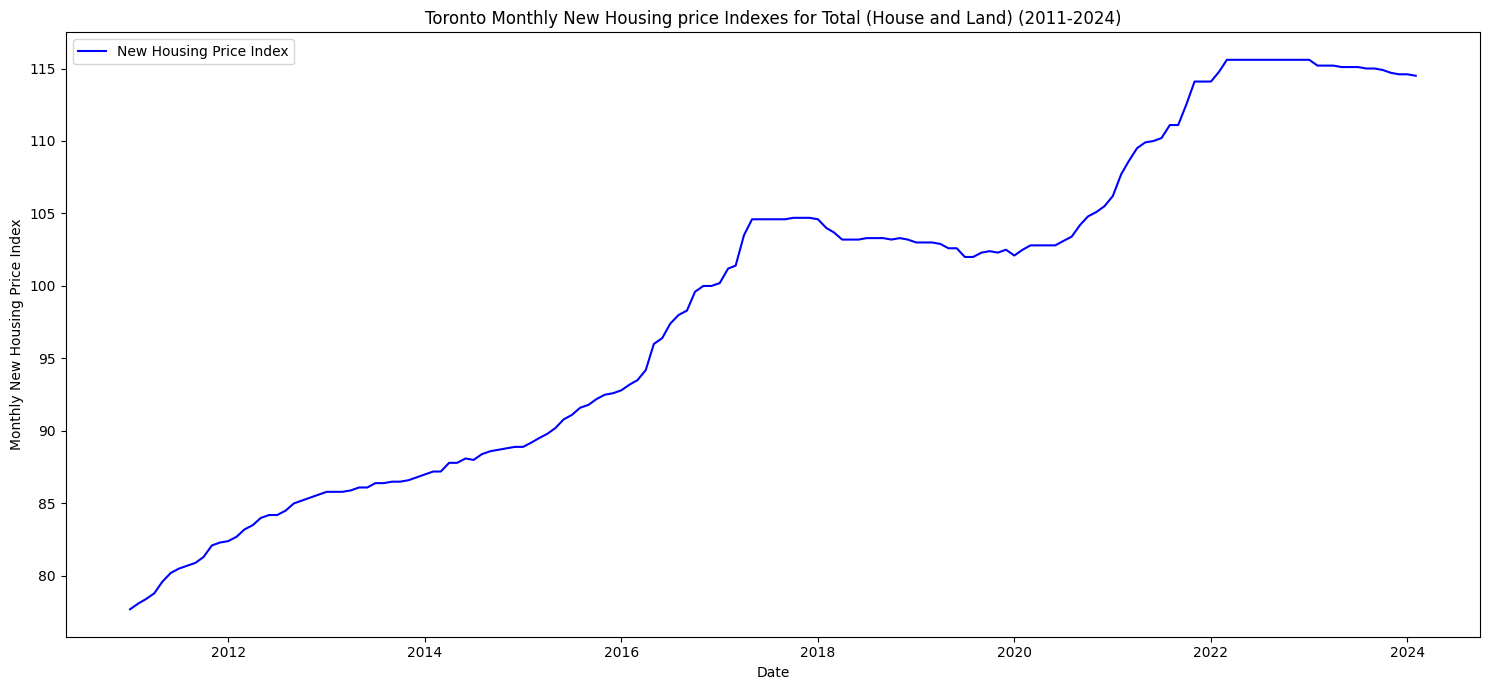

In [57]:
# PLOTTING MONTHLY NEW HOUSING PRICE INDEXES -----------------------------------------

house_df['REF_DATE'] = pd.to_datetime(house_df['REF_DATE'])

register_matplotlib_converters()

plt.figure(figsize=(15, 7))

plt.plot(house_df['REF_DATE'], house_df['VALUE'], label='New Housing Price Index', color='blue')

plt.title('Toronto Monthly New Housing price Indexes for Total (House and Land) (2011-2024)')
plt.xlabel('Date')
plt.ylabel('Monthly New Housing Price Index')
plt.legend()

plt.tight_layout()

plt.show()
